<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./31_ltpy_v01_AC_SAF_L2_case_study.ipynb"><< 31 - AC SAF Level 2 - Case studies </a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./index_ltpy_v01.ipynb">Index >></a>

# 3.2 AC SAF Level 3 - Workflow examples

The AC SAF Level 3 longterm monthly average data products are helpful to get a better overall picture of an atmospheric compostion parameter. Following workflows will help to get a better understanding of the behaviour of one specific parameter:
* <b>Visualization of global monthly aggregates</b><br>
    We can visualize the monthly aggregates on a `2D Map`
* <b>Visualization of a longterm trend for one specific location or region</b><br>
    We can generate a `time series plot` and visualize the longterm trend for one specific location. We can also compare two different locations and data values can also be spatially aggregated to visualize the global or regional longterm trend

    
For all examples, we will make use of the `xarray` library. `xarray` offers useful functions and wrappers for the efficient handling of multi-dimensional data in `netCDF`.

<br>

This notebook contains examples of the Level 3 data product `Nitrogen dioxide`. At the beginning, there is a section that loads required libraries and the Level 3 data product as xarray `Datasets`. Some functions that will be reused will be defined as well.

#### Module outline:
* **[Nitrogen dioxide - Workflow example](#no2)**
 * [1 - Explore data with a 2D Map](#2d_map)
 * [2 - Explore longterm trends of tropospheric column NO2 for specific locations](#trends)
 * [3 - Add standard deviation information to tropospheric column NO2 levels for specific locations](#std)

<hr>

#### Load required libraries

In [14]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load Level 3 data products as xarray `Datasets`

In [15]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-02', '2017-11', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2007-02-01', '2007-03-01', '2007-04-01', '2007-05-01',
               '2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', length=130, freq=None)

##### Load NO<sub>2</sub> data products

In [17]:
no2_ds = xr.open_dataset('./eodata/gome2/level3/no2/GOME_NO2_Global_201701_METOPB_DLR_v1.nc')
no2 = xr.open_mfdataset('./eodata/gome2/level3/no2/*.nc', concat_dim='time',  group='PRODUCT')

no2_assigned = no2.assign_coords(latitude=no2_ds.latitude, longitude=no2_ds.longitude, time=time_coords)
no2_assigned

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Coordinates:
  * latitude         (latitude) float32 -89.875 -89.625 ... 89.625 89.875
  * longitude        (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * time             (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-11-01
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<shape=(130, 720, 1440), chunksize=(1, 720, 1440)>
    NO2total_err     (time, latitude, longitude) float32 dask.array<shape=(130, 720, 1440), chunksize=(1, 720, 1440)>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<shape=(130, 720, 1440), chunksize=(1, 720, 1440)>
    NO2trop          (time, latitude, longitude) float32 dask.array<shape=(130, 720, 1440), chunksize=(1, 720, 1440)>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<shape=(130, 720, 1440), chunksize=(1, 720, 1440)>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.arra

<hr>

#### Visualization functions

##### Visualize a `2D xarray DataArray` with `matplotlib` and `cartopy`

We can make use of the function `visualize_imshow`, which we defined in module [22_ltpy_v01_AC_SAF_L3_data_products](./22_ltpy_v01_AC_SAF_L3_data_products.ipynb#plotting). We just have to adjust it that the function accounts for multi-dimensional `DataArrays`. Let's call the modified function `visualize_map`.

In [18]:
def visualize_map(array, conversion_factor, timepos, projection, vmax, color_scale):
    fig=plt.figure(figsize=(15, 10))

    ax=plt.axes(projection=projection)
    ax.coastlines()
    ax.set_global()
    
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)

    ax.set_title(array.long_name, fontsize=20, pad=20.0)

    tmp = array[timepos,:,:]
    img1 = plt.imshow(tmp*conversion_factor,
               extent=[array.longitude.min(),array.longitude.max(),array.latitude.max(),array.latitude.min()],
               cmap=color_scale,
               aspect='auto',
               vmin=0,
               vmax=vmax)

    cbar = fig.colorbar(img1, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(str(conversion_factor) + ' ' + array.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    plt.show()

<hr>

## <a id="no2"></a>Nitrogen dioxide - Workflow example

### <a id="2d_map"></a>1) Explore data with a `2D Map`

A first step is to explore the data is to create a simple `2D Map`. We defined the function `visualize_map`, which takes the following kwargs:
* a xarray `DataArray`, 
* the index of the time axis (month-1 that shall be plotted),
* the projection,
* maximum data value to adjust the colorbar,
* a title for the plot, and
* the unit for the y-axis

You can explore different months by changing the number of the month.

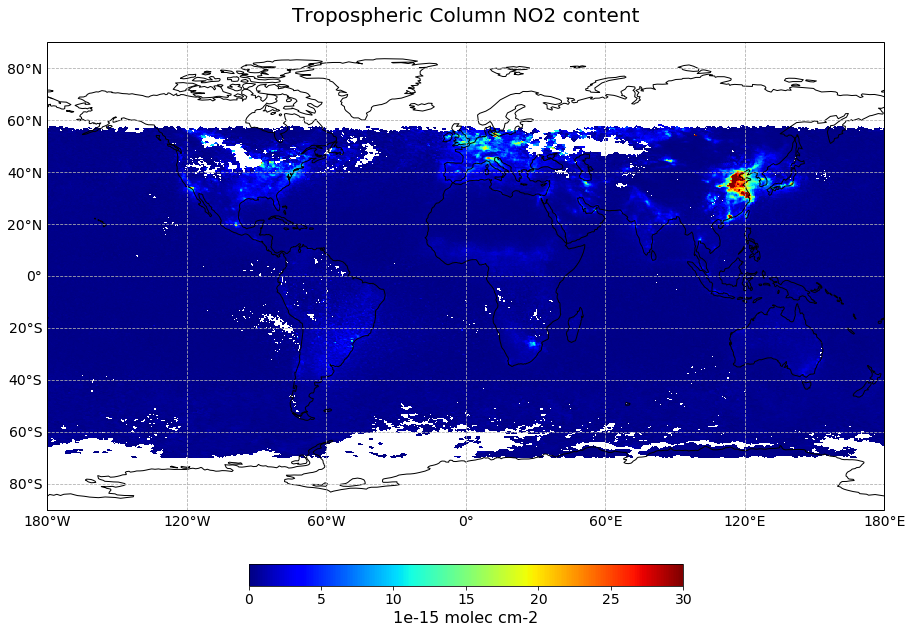

In [19]:
month = 10 # in Python iterations start at 0, thus 10 equals data values for month November

visualize_map(no2_assigned.NO2trop, 1e-15, month, ccrs.PlateCarree(), 30, 'jet')

<br>

### <a id="trends"></a>2) Explore longterm trends of tropospheric column NO<sub>2</sub> for specific locations

The above map shows us that there is a prominent increase of the tropospheric column of nitrogen dioxide in the Beijing region. Let's have a look at the longterm trend for individual point locations.

xarray's label based selection method `sel` allows to select data based on name or value. `sel` further allows for enabling nearest neighbor, which select the closes e.g. latitude or longitude value. xarray offers a simple plotting wrapper of Python's matplotlib. Thus, we can directly apply the `plot` function to a `DataArray` object. We can add additional specifications, e.g. if it shall be a line plot, what color and style the line shall have, etc.


Let's plot the temporal trends for two locations: `Beijing` and `Darmstadt`, to see how much more the tropospheric NO<sub>2</sub> levels in Beijing are elevated compared to a city in Germany. We specify latitude and longitude coordinates for both cities and plot the two DataArrays as line plots.

NOTE: the NO<sub>2</sub> values are shown in 1e<sup>-15</sup> molecules per cm<sup>2</sup>.

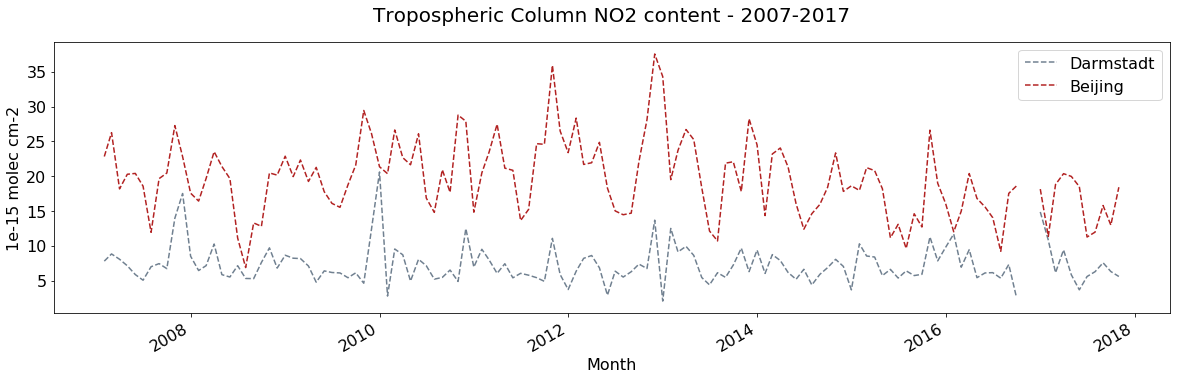

In [20]:
fig = plt.figure(figsize=(20,5))

# Latitude / Longitude coordinates for Darmstadt
city1 = 'Darmstadt'
lat1 = 49.875
lon1 = 8.650

# Latitude / Longitude coordinates for Beijing
city2 = 'Beijing'
lat2 = 39.908
lon2 = 116.397

conversion_factor = 1e-15

city1_total = no2_assigned.NO2trop.sel(latitude=lat1, longitude=lon1, method='nearest')*conversion_factor
city1_total.plot.line(color='slategrey', linestyle='dashed', label=city1)

city2_total = no2_assigned.NO2trop.sel(latitude=lat2, longitude=lon2, method='nearest')*conversion_factor
city2_total.plot.line(linestyle='dashed',color='firebrick', label=city2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(no2_assigned.NO2trop.long_name + " - 2007-2017", fontsize=20, pad=20)
plt.ylabel(str(conversion_factor) + ' ' + no2_assigned.NO2trop.units, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

<br>

The plot above shows that the NO<sub>2</sub> levels in Beijing are in general higher than the levels in Darmstadt.

There is a prominent spike of tropospheric NO<sub>2</sub> levels in Beijing in January 2013, which reflects the [Heavy haze pollution episode over central and western China](https://link.springer.com/article/10.1007/s11430-013-4773-4).

<br>

<br>

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>